# Data Augmentation with cGANs for Improved Prostate Segmentation

## Abstract

Segmentation of medical images has many diverse applications, ranging from surgical planning to disease diagnosis. Machine learning approaches to segmentation using deep convolutional neural networks (CNNs) have demonstrated state-of-theart results compared to the current gold-standard of manual segmentation. However, CNNs require large amounts of labeled training data and it is often impractical to obtain a sufficient number of medical images to successfully develop segmentation models. We present a novel method of data augmentation to increase the size of the labeled training set, involving a conditional generative adversarial network (cGAN) which is used to generate labeled synthetic data. First, a U-Net is trained on the segmentation task using the available data. Then, segmentations corresponding to an anatomical atlas are fed back through a new U-Net to generate synthetic data. This backward fed U-Net is used as the generator of the cGAN, which has in-effect been pre-trained using the reverse segmentation task. The addition of the discriminator fine-tunes the output to encourage realistic synthetic data which corresponds to the conditioned segmentation mask (i.e. result is a labeled training example). Our model is demonstrated on the Medical Segmentation Decathlon Prostate dataset consisting of 32 T2 weighted MRI volumes and shows improved segmentation performance compared to the non-augmented dataset.

# Data Set

The data set can be downloaded from this URL: https://drive.google.com/open?id=1Ff7c21UksxyT4JfETjaarmuKEjdqe1-a
Training and validation data can split into testing and training folders, and has been done so already.

# Step 1: Establishing Baseline UNet

The first thing is to establish a baseline that can be used to compare the experimental model to. This is used using three codes in combination; a Data generator, a Trainer, and a Predictor. Full documentation can be found within each respective script. 

In [ ]:
from Trainer import Trainer
from Predictor import Predictor
import os
import keras as K

'''This script is used to train a basic UNet on prostate segmentation in
MRI. This will be used as a base line in our project. It is traained on
75% of the volumes, resampled to istropic voxel size of 2.0. It is then tested on 25% of the volumes,
resampled the same, resulting in 278 testing examples.
'''

### Train the Model

# Change these folders to your desired directories.
data_dir_train = 'D:/prostate_data/Task05_Prostate/imagesTr/'

target_dir_train = 'D:/prostate_data/Task05_Prostate/labelsTr/'

data_dir_val = 'D:/prostate_data/Task05_Prostate/imagesTs/'

target_dir_val = 'D:/prostate_data/Task05_Prostate/labelsTs/'

ofolder = 'ModelOutputs/UNet_regular'

if 'CUDA_VISIBLE_DEVICES' in os.environ.keys():
    CUDA_VISIBLE_DEVICES = os.environ['CUDA_VISIBLE_DEVICES'].split(',')
else:
    CUDA_VISIBLE_DEVICES = ['None']

a = Trainer(data_dir_train, target_dir_train, ofolder, samples_per_card=None,
            epochs=50, gpus_used=len(CUDA_VISIBLE_DEVICES), num_classes=1,
            batch_size=16, training_direction=True,
            batch_folder_val=data_dir_val, target_folder_val=target_dir_val
            )

# Uncomment when training
# a.train_the_model(t_opt=K.optimizers.adam(lr=1e-5)) 

### Test the Model
# Change these folders to your desired directories.
data_dir_val = 'D:/prostate_data/Task05_Prostate/imagesTs/'

target_dir_val = 'D:/prostate_data/Task05_Prostate/labelsTs/'

model_folder = 'ModelOutputs/UNet_regular'

ofolder = 'ModelOutputs/UNet_regular/test_results'

a = Predictor(model_folder=model_folder,
              data_folder=data_dir_val,
              target_folder=target_dir_val,
              ofolder=ofolder,
              opt='ADAM',
              testing_direction=True)

# Uncomment when prediction and evaluating the model
# a.predict_and_evaluate()
print('done')

Model is ready to predict.
done


Note that the above paths should be changed to where the data is stored when running the code; the paths here are only an example. Also, `a.train_the_model` and `a.predict_and_evaluate()` need to be uncommented for above code to work.

# Step 2: Pre-Training the U-Net Generrator

For the next step the generator to the cGAN is pre-trained. This is done by training the U-Net in reverse to pre-train weights to generate images given the segmentation ground truth. This just sets the `training_direction=False` and runs the trainer again.

In [5]:
from Trainer import Trainer
import os
import keras as K

import tensorflow as tf
import numpy as np

tf.set_random_seed(1)
np.random.seed(1)

# Train the Augmentation Model

data_dir = 'D:/prostate_data/Task05_Prostate/imagesTr/'
target_dir = 'D:/prostate_data/Task05_Prostate/labelsTr/'

ofolder = 'ModelOutputs/UNetAugmentor/'


if 'CUDA_VISIBLE_DEVICES' in os.environ.keys():
    CUDA_VISIBLE_DEVICES = os.environ['CUDA_VISIBLE_DEVICES'].split(',')
else:
    CUDA_VISIBLE_DEVICES = ['None']


a = Trainer(data_dir, target_dir, ofolder, samples_per_card=None,
            epochs=100, gpus_used=len(CUDA_VISIBLE_DEVICES),
            batch_size=16, training_direction=False)

# Uncomment when training
# a.train_the_model(t_opt=K.optimizers.adam(lr=1e-4),
#                   loss=K.losses.mae,
#                   t_dropout=0)

print('done')

done


Again, as above the paths can be changed to where the data is actually saved when running, and `a.train_the_model()` needs to be uncommented for model to actually train. 

# Step 3: Fine Tuning the U-Net Generator in a GANs training Framework

This script is based on the *Pix2Pix* model structure found at https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

In [2]:
from Pix2Pix import Pix2Pix

import tensorflow as tf
import numpy as np


# Train the Augmentation Model using a cGAN

data_dir = 'D:/prostate_data/Task05_Prostate/imagesTr/'
target_dir = 'D:/prostate_data/Task05_Prostate/labelsTr/'

pretrained_model = 'ModelOutputs/UNetAugmentor/'
ofolder = 'ModelOutputs/cGANUnetAugmentor/'

tf.set_random_seed(1)
np.random.seed(1)

cgan = Pix2Pix(pretrained_folder=pretrained_model,
               data_dir=data_dir,
               target_dir=target_dir,
               ofolder=ofolder,
               batch_size=32)

# Uncomment when training
# cgan.train(epochs=20, sample_interval=1000)

print('done')

done


Again, as above the paths can be changed to where the data is actually saved when running, and `cgan.train()` needs to be uncommented for model to actually train. 

# Step 4: Training and Testing using the cGAN trained U-Net Generator

This is mostly just a repeat of Step 1 above, just changing the model. The one main difference is that the U-Net is trained using different number of synthetic training examples. 

In [1]:
from Trainer import Trainer
from Predictor import Predictor
import os
import keras as K
import numpy as np


# Train the Model

data_dir_train = 'D:/prostate_data/Task05_Prostate/imagesTr/'

target_dir_train = 'D:/prostate_data/Task05_Prostate/labelsTr/'

data_dir_val = 'D:/prostate_data/Task05_Prostate/imagesTs/'

target_dir_val = 'D:/prostate_data/Task05_Prostate/labelsTs/'

aug_folder = 'ModelOutputs/cGANUnetAugmentor/'

num_syn_data_vec = np.linspace(100, 2000, 20)

for num_syn_data in num_syn_data_vec:

    ofolder = 'ModelOutputs/UNet_regularWAugcGAN/{}_syn_samples/'.format(int(num_syn_data))

#     if os.path.exists(ofolder) is False:

#         os.makedirs(ofolder)

    if 'CUDA_VISIBLE_DEVICES' in os.environ.keys():
        CUDA_VISIBLE_DEVICES = os.environ['CUDA_VISIBLE_DEVICES'].split(',')
    else:
        CUDA_VISIBLE_DEVICES = ['None']

    a = Trainer(data_dir_train, target_dir_train, ofolder, samples_per_card=None,
                epochs=50, gpus_used=len(CUDA_VISIBLE_DEVICES), num_classes=1,
                batch_size=16, training_direction=True,
                aug_folder=aug_folder,
                data_aug=True, num_syn_data=int(num_syn_data),
                batch_folder_val=data_dir_val, target_folder_val=target_dir_val
                )
    
#     Uncomment when training
#     a.train_the_model(t_opt=K.optimizers.adam(lr=1e-5))

    # Test the Model

    data_dir = 'D:/prostate_data/Task05_Prostate/imagesTs/'
    target_dir = 'D:/prostate_data/Task05_Prostate/labelsTs/'
    
    model_folder = ofolder

    ofolder_pred = ofolder + 'test_results'

    a = Predictor(model_folder=model_folder,
                  data_folder=data_dir,
                  target_folder=target_dir,
                  ofolder=ofolder_pred,
                  opt='ADAM',
                  testing_direction=True)
    
    # Uncomment when running
#     a.predict_and_evaluate()

print('done')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
done


# Results

## Synthetic Data Image

The synthetic images after the cGAN can be seen below.

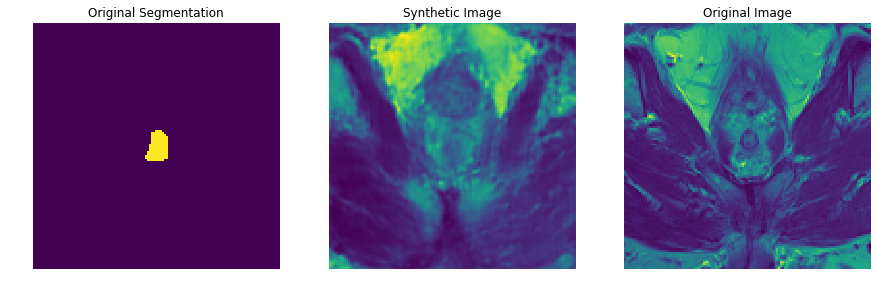

In [68]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from TrainingUtils import dice_loss, dice_coef
import DGenerator as generator
from keras.models import model_from_json
import os

model_folder_pretrain = 'ModelOutputs/UNetAugmentor_rev3/'
model_folder_cgan = 'ModelOutputs/cGANUnetAugmentor_rev2/'

data_dir_train = 'D:/prostate_data/Task05_Prostate/imagesTr/'
target_dir_train = 'D:/prostate_data/Task05_Prostate/labelsTr/'

data_dir_val = 'D:/prostate_data/Task05_Prostate/imagesTs/'
target_dir_val = 'D:/prostate_data/Task05_Prostate/labelsTs/'


# Load cGAN model
json_file_name = [i for i in os.listdir(model_folder_cgan) if i.endswith('json')][0]
weights_file_name = [i for i in os.listdir(model_folder_cgan) if i.startswith('model_best')][0]
json_file = open(''.join([model_folder_cgan, '/', json_file_name]))
loaded_model_json = json_file.read()
json_file.close()
model_cgan = model_from_json(loaded_model_json)

model_cgan.load_weights(''.join([model_folder_cgan, '/', weights_file_name]))
model_cgan.compile(loss=dice_loss, metrics=[dice_coef], optimizer='ADAM')

gen = generator.DGenerator(data_dir=data_dir_val,
                           target_dir=target_dir_val,
                           batch_size=1,
                           regular=True,
                           shuffle=False,
                           num_classes=1)
test_set, test_tar = gen.__getitem__(5)

pred_img_cgan = model_cgan.predict(test_tar)

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(test_tar[0, :, :, 0])
ax1.set_title('Original Segmentation')
ax1.axis('off')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(pred_img_cgan[0, :, :, 0])
ax2.set_title('Synthetic Image')
ax2.axis('off')

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(test_set[0, :, :, 0])
ax3.set_title('Original Image')
ax3.axis('off')

plt.show()

## Determining Best Synthetic Training Data Amount

Now that all the training is done with the different synthetic data amounts, which one performed the best needs to be determined.

In [4]:
import os
import pandas as pd
import numpy as np

main_model_folder = 'ModelOutputs/UNet_regularWAugcGAN'

dsc_avg = []
dsc_std = []

syn_amount = []

for syn_sample_folder in os.listdir(main_model_folder):

    csv_folder_path = '/'.join([main_model_folder,
                                syn_sample_folder,
                                'test_results/evaluation_results.csv'])

    syn_sample_number = int(syn_sample_folder.split('_')[0])

    df = pd.read_csv(csv_folder_path)

    dsc_avg_hold = df['Dice coefficient'].values.mean()
    dsc_std_hold = df['Dice coefficient'].values.std()

    dsc_avg.append(dsc_avg_hold)
    dsc_std.append(dsc_std_hold)
    syn_amount.append(syn_sample_number)

dsc_avg = np.array(dsc_avg)
dsc_std = np.array(dsc_std)

syn_amount = np.array(syn_amount)

sort_idx = np.argsort(syn_amount)

syn_amount = syn_amount[sort_idx]
dsc_avg = dsc_avg[sort_idx]
dsc_std = dsc_std[sort_idx]

max_syn_amount_idx = dsc_avg.argmax()

print('{} synthetic samples have the highest average DSC.'.format(syn_amount[max_syn_amount_idx]))

print(u'Highest average DSC \u00b1 standard deviation were: {:0.3f} \u00b1 {:0.3f}'.format(
    dsc_avg[max_syn_amount_idx],
    dsc_std[max_syn_amount_idx]))

baseline_results_csv = 'ModelOutputs/UNet_regular/test_results/evaluation_results.csv'

dsc_baseline = pd.read_csv(baseline_results_csv)['Dice coefficient'].values

dsc_baseline_avg = dsc_baseline.mean()
dsc_baseline_std = dsc_baseline.std()

print()
print(u'The baseline U-Net had an average DSC \u00b1 standard deviation of: {:0.2f} \u00b1 {:0.2f}'.format(
    dsc_baseline_avg,
    dsc_baseline_std))

1700 synthetic samples have the highest average DSC.
Highest average DSC ± standard deviation were: 0.763 ± 0.179

The baseline U-Net had an average DSC ± standard deviation of: 0.74 ± 0.19


This showed us that at 1700 synthetic samples provided the best DSC and it was larger than the baseline. 

# Visualization

## Plot Images

Here is an example of the images plotted. The code can also be seen in `plot_image.py`.

Below shows an example using the baseline U-Net.

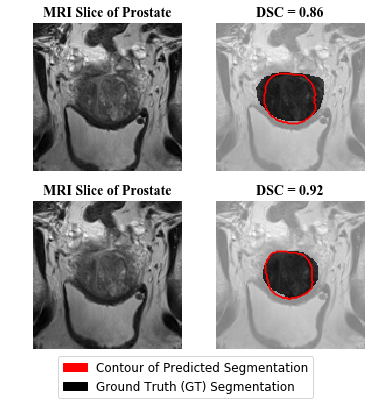

In [14]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

import DGenerator as generator

data_dir = 'D:/prostate_data/Task05_Prostate/imagesTs/'
target_dir = 'D:/prostate_data/Task05_Prostate/labelsTs/'
model_folder = 'ModelOutputs/UNet_regular_rev/'


gen = generator.DGenerator(data_dir=data_dir, target_dir=target_dir, batch_size=1, regular=True, shuffle=False)
gen.batch_size = gen.__len__()
test_set, test_tar = gen.__getitem__(0)

y_pred_hold = np.load(model_folder + '/test_results/pred_TestSet.npy')
y_pred = np.where(y_pred_hold >= 0.5, 1, 0)

pred_shape = y_pred.shape

# If prediction is accidentally channels first, fix
if pred_shape[1] != pred_shape[2]:
    y_pred = np.rollaxis(y_pred, axis=1, start=4)

dice_coefficient = []

for index in range(y_pred.shape[0]):
    # prep the data
    predicted_volume = y_pred[index, :, :, :].astype('float32')
    target_volume = test_tar[index, :, :, :]

    dice_coefficient_hold = dice_coefficient_numpy_arrays(target_volume[:, :, 0], predicted_volume[:, :,0])
    dice_coefficient.append(dice_coefficient_hold)

dice_coefficient = np.array(dice_coefficient)
sort_idx = np.argsort(dice_coefficient)[::-1]

idx_hold_tot = [211, 212]

fig = plt.figure(figsize=(6, 6))
sub_plot_idx = 0

for idx in range(2):

    idx_hold = idx_hold_tot[idx]
    DSC = dice_coefficient[idx_hold]

    ground_truth_data = test_tar[idx_hold, :, :,0]
    pred_data = y_pred[idx_hold, :, :,0]
    test_data = test_set[idx_hold, :, :,0]

    ax1 = fig.add_subplot(2, 2, sub_plot_idx + 1)
    sub_plot_idx += 1
    plt1 = ax1.imshow(test_data, cmap='gray')

    ax1.set_title('MRI Slice of Prostate', fontsize=14, fontname='Times New Roman')

    ax2 = fig.add_subplot(2, 2, sub_plot_idx + 1)
    sub_plot_idx += 1

    plt1 = ax2.imshow(ground_truth_data, cmap='Greys')
    plt2 = ax2.imshow(test_data, cmap='gray', alpha=0.5)
    plt3 = ax2.contour(pred_data, colors='r', linewidths=0.5)

    ax2.set_title(r'DSC = {:.2f}'.format(DSC), fontsize=14, fontname='Times New Roman')

    ax1.axis('off')
    ax2.axis('off')


red_patch = mpatches.Patch(color='red', label='Contour of Predicted Segmentation')
black = mpatches.Patch(color='k', label='Ground Truth (GT) Segmentation')
plt.figlegend(handles=[red_patch, black], loc='lower center', fontsize=12)

plt.show()

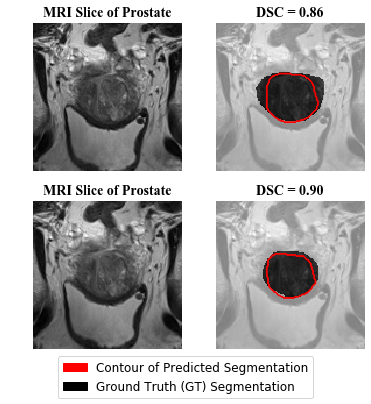

In [16]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

import DGenerator as generator

data_dir = 'D:/prostate_data/Task05_Prostate/imagesTs/'
target_dir = 'D:/prostate_data/Task05_Prostate/labelsTs/'
model_folder = 'ModelOutputs/UNet_regularWAugcGAN_rev/1700_syn_samples/'


gen = generator.DGenerator(data_dir=data_dir, target_dir=target_dir, batch_size=1, regular=True, shuffle=False)
gen.batch_size = gen.__len__()
test_set, test_tar = gen.__getitem__(0)

y_pred_hold = np.load(model_folder + '/test_results/pred_TestSet.npy')
y_pred = np.where(y_pred_hold >= 0.5, 1, 0)

pred_shape = y_pred.shape

# If prediction is accidentally channels first, fix
if pred_shape[1] != pred_shape[2]:
    y_pred = np.rollaxis(y_pred, axis=1, start=4)

dice_coefficient = []

for index in range(y_pred.shape[0]):
    # prep the data
    predicted_volume = y_pred[index, :, :, :].astype('float32')
    target_volume = test_tar[index, :, :, :]

    dice_coefficient_hold = dice_coefficient_numpy_arrays(target_volume[:, :, 0], predicted_volume[:, :,0])
    dice_coefficient.append(dice_coefficient_hold)

dice_coefficient = np.array(dice_coefficient)
sort_idx = np.argsort(dice_coefficient)[::-1]

idx_hold_tot = [211, 212]

fig = plt.figure(figsize=(6, 6))
sub_plot_idx = 0

for idx in range(2):

    idx_hold = idx_hold_tot[idx]
    DSC = dice_coefficient[idx_hold]

    ground_truth_data = test_tar[idx_hold, :, :, 0]
    pred_data = y_pred[idx_hold, :, :, 0]
    test_data = test_set[idx_hold, :, :, 0]

    ax1 = fig.add_subplot(2, 2, sub_plot_idx + 1)
    sub_plot_idx += 1
    plt1 = ax1.imshow(test_data, cmap='gray', label='Ground Truth Segmentation')

    ax1.set_title('MRI Slice of Prostate', fontsize=14, fontname='Times New Roman')

    ax2 = fig.add_subplot(2, 2, sub_plot_idx + 1)
    sub_plot_idx += 1

    plt1 = ax2.imshow(ground_truth_data, cmap='Greys', label='Ground Truth Segmentation')
    plt2 = ax2.imshow(test_data, cmap='gray', alpha=0.5, label='Testing Sample')
    plt3 = ax2.contour(pred_data, colors='r', linewidths=0.5, label='Segmentation Prediction')

    ax2.set_title(r'DSC = {:.2f}'.format(DSC), fontsize=14, fontname='Times New Roman')

    ax1.axis('off')
    ax2.axis('off')

red_patch = mpatches.Patch(color='red', label='Contour of Predicted Segmentation')
black = mpatches.Patch(color='k', label='Ground Truth (GT) Segmentation')
plt.figlegend(handles=[red_patch, black], loc='lower center', fontsize=12)

plt.show()

## Plot Histograms

The last part of the results is plotting the histograms of the data.

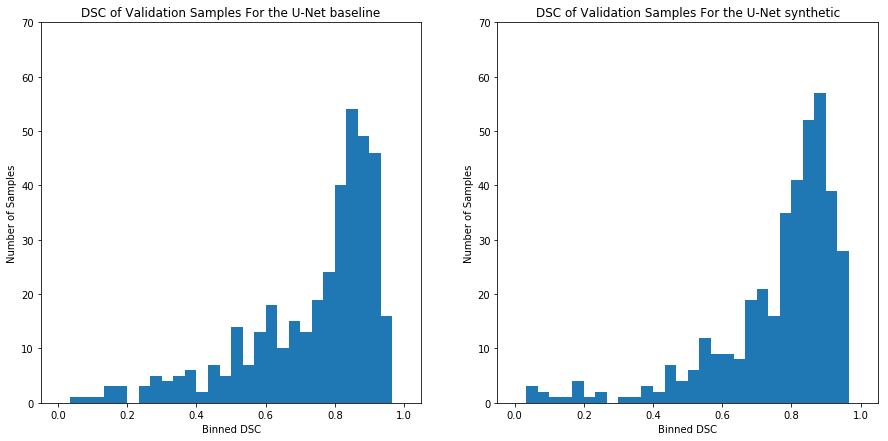

In [59]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

csv_dir_syn = 'ModelOutputs/UNet_regularWAugcGAN/1700_syn_samples/test_results/evaluation_results.csv'
csv_dir_baseline = 'ModelOutputs/UNet_regular/test_results/evaluation_results.csv'

df_base = pd.read_csv(csv_dir_baseline, index_col=False)
dsc_base_list = df_base['Dice coefficient'].values

df_syn = pd.read_csv(csv_dir_syn, index_col=False)
dsc_syn_list = df_syn['Dice coefficient'].values

bin_range = np.linspace(0, 1, 31)

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylim([0, 70])
ax1.hist(dsc_base_list, bins=bin_range)
ax1.set_title('DSC of Validation Samples For the U-Net baseline')
plt.xlabel('Binned DSC')
plt.ylabel('Number of Samples')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_ylim([0, 70])
ax2.hist(dsc_syn_list, bins=bin_range)
ax2.set_title('DSC of Validation Samples For the U-Net synthetic')
plt.xlabel('Binned DSC')
plt.ylabel('Number of Samples')

plt.show()